# Satellite Imagery Land Cover Semantic Segmentation

The dataset is obtained from https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset/data.

The original source of data is from the DeepGlobe Land Cover Classification Challenge (https://competitions.codalab.org/competitions/18468).

Data citation:

`@InProceedings{DeepGlobe18,
 author = {Demir, Ilke and Koperski, Krzysztof and Lindenbaum, David and Pang, Guan and Huang, Jing and Basu, Saikat and Hughes, Forest and Tuia, Devis and Raskar, Ramesh},
 title = {DeepGlobe 2018: A Challenge to Parse the Earth Through Satellite Images},
 booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops},
 month = {June},
 year = {2018}
}`




## Project Setup

In [ ]:
# Install required libs
!pip install segmentation-models-pytorch
!pip install lightning

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd  /content/drive/MyDrive/CVProject/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1g4JweDAJKskfNoFFeVBg5Qcv5wAXrZX9/CVProject


## Data Preparation

In [ ]:
import torch
import pandas as pd

class_dict = pd.read_csv("class_dict.csv")
print(class_dict)
rgb_class_map = dict(((row["r"], row["g"], row["b"]), i) for i, row in class_dict.iterrows())
class_rgb_map = dict((i, (row["r"], row["g"], row["b"])) for i, row in class_dict.iterrows())
N = len(class_dict)

def binarize(tensor):
    return torch.where(tensor > 128, 255, 0)

# RGB to (H, W)
def encode_by_class(tensor):
    encoded = torch.empty(tensor.shape[1], tensor.shape[2], dtype=torch.uint8)

    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[2]):
            t = tuple(binarize(tensor[:, i, j]).tolist())
            c = rgb_class_map[t]
            encoded[i, j] = c

    return encoded

# (H, W) to RGB
def decode_by_class(tensor):
    decoded = torch.empty(3, tensor.shape[0], tensor.shape[1], dtype=torch.uint8)

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            c = tensor[i, j].item()
            decoded[:, i, j] = torch.tensor(class_rgb_map[c])

    return decoded

# # RGB to (C, H, W)
# def one_hot_encode(tensor):
#     encoded = torch.zeros(N, tensor.shape[1], tensor.shape[2], dtype=torch.uint8)

#     for i in range(tensor.shape[1]):
#         for j in range(tensor.shape[2]):
#             t = tuple(binarize(tensor[:, i, j]).tolist())
#             c = rgb_class_map[t]
#             encoded[c, i, j] = 1

#     return encoded

# # (C, H, W) to RGB
# def one_hot_decode(tensor):
#     decoded = torch.empty(3, tensor.shape[1], tensor.shape[2], dtype=torch.uint8)

#     for i in range(tensor.shape[1]):
#         for j in range(tensor.shape[2]):
#             c = tensor[:, i, j].argmax(dim=0).item()
#             decoded[:, i, j] = torch.tensor(class_rgb_map[c])

#     return decoded

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2
import torchvision.transforms.v2.functional as TF

NUM_TRAIN = 640 # 80%
NUM_VAL = 80 # 10%
NUM_TEST = 80 # 10%

class DeepGlobeLandCover(Dataset):
    # type: 0 for train, 1 for val, 2 for test
    def __init__(self, metadata_file, type=0):
        self.metadata = pd.read_csv(metadata_file, usecols=['image_id', 'sat_image_path', 'mask_path'])

        if type == 1:
          self.metadata = self.metadata[NUM_TRAIN:NUM_TRAIN+NUM_VAL]
          self.metadata.reset_index(drop=True, inplace=True)
        elif type == 2:
          self.metadata = self.metadata[NUM_TRAIN+NUM_VAL:NUM_TRAIN+NUM_VAL+NUM_TEST]
          self.metadata.reset_index(drop=True, inplace=True)
        else:
          self.metadata = self.metadata[:NUM_TRAIN]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        image = read_image(self.metadata.loc[idx, 'sat_image_path'])
        mask = read_image(self.metadata.loc[idx, 'mask_path'])

        i, j, h, w = v2.RandomCrop.get_params(image, (512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        mask = encode_by_class(mask)

        return image.float(), mask.long()

trainset = DeepGlobeLandCover('metadata.csv', 0)
valset = DeepGlobeLandCover('metadata.csv', 1)
testset = DeepGlobeLandCover('metadata.csv', 2)

trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
import matplotlib.pyplot as plt

def visualize(images, masks, pred_masks = None):
    num_rows = len(images)
    fig, axs = plt.subplots(num_rows, 2) if pred_masks is None else plt.subplots(num_rows, 3)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    for i in range(num_rows):
        axs[i, 0].imshow(images[i].int().permute(1, 2, 0))
        axs[i, 0].set_axis_off()
        axs[i, 1].imshow(decode_by_class(masks[i]).int().permute(1, 2, 0))
        axs[i, 1].set_axis_off()

        if pred_masks is not None:
            axs[i, 2].imshow(decode_by_class(pred_masks[i]).int().permute(1, 2, 0))
            axs[i, 2].set_axis_off()

    plt.show()

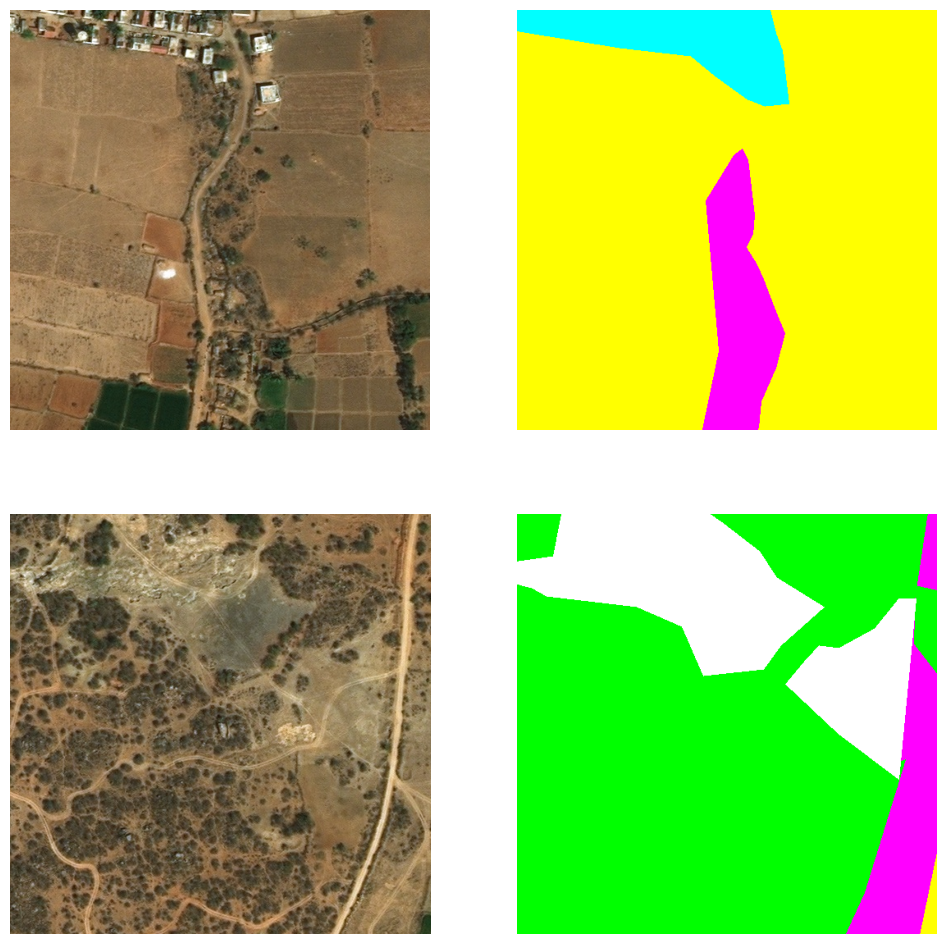

In [ ]:
images, masks = next(iter(trainloader))
visualize(images[4:6, :, :], masks[4:6, :, :])

## Model

In [12]:
import lightning as L
import segmentation_models_pytorch as smp

class LandCoverModel(L.LightningModule):
    def __init__(self, arch, encoder_name, encoder_weights, in_channels, num_classes):
        super().__init__()

        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=num_classes
        )
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

    def forward(self, image):
        mask = self.model(image)

        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.softmax(dim=1)
        pred_mask = prob_mask.argmax(dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask, mask.int(), mode=smp.losses.MULTICLASS_MODE, num_classes=N)
        # the formula used by smp.metrics.functional.precision actually calculates accuracy due to the "micro-imagewise" reduction
        accuracy = smp.metrics.functional.precision(tp, fp, fn, tn, reduction="micro-imagewise")

        self.log(f"{stage}_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log(f"{stage}_accuracy", accuracy, on_step=True, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)

        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.65, verbose=True)
        }

In [ ]:
model = LandCoverModel("Unet", "resnet50", "imagenet", in_channels=3, num_classes=N)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


## Training

In [ ]:
import os
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer

logger = CSVLogger("/content/drive/MyDrive/CVProject")
trainer = Trainer(logger=logger, max_epochs=10, log_every_n_steps=2)

trainer.fit(
    model,
    train_dataloaders=trainloader,
    val_dataloaders=valloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model,
    train_dataloaders=trainloader,
    val_dataloaders=valloader,
    ckpt_path="lightning_logs/version_16/checkpoints/epoch=3-step=320.ckpt"
)

INFO: Restoring states from the checkpoint path at lightning_logs/version_16/checkpoints/epoch=3-step=320.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/version_16/checkpoints/epoch=3-step=320.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:347: The dirpath has changed from '/content/drive/MyDrive/CVProject/lightning_logs/version_16/checkpoints' to '/content/drive/MyDrive/CVProject/lightning_logs/version_21/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 32.5 M
1 | loss_fn | DiceLoss | 0     
---------------------------------

Adjusting learning rate of group 0 to 1.7851e-05.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1603e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5419e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9022e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Predictions

In [13]:
model = LandCoverModel.load_from_checkpoint(
    "lightning_logs/version_20/checkpoints/epoch=6-step=560.ckpt",
    arch="Unet",
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    num_classes=N
)
trainer.test(model=model, dataloaders=testloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8061480522155762     │
│      test_loss_epoch      │    0.3451550304889679     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.3451550304889679,
  'test_accuracy_epoch': 0.8061480522155762}]

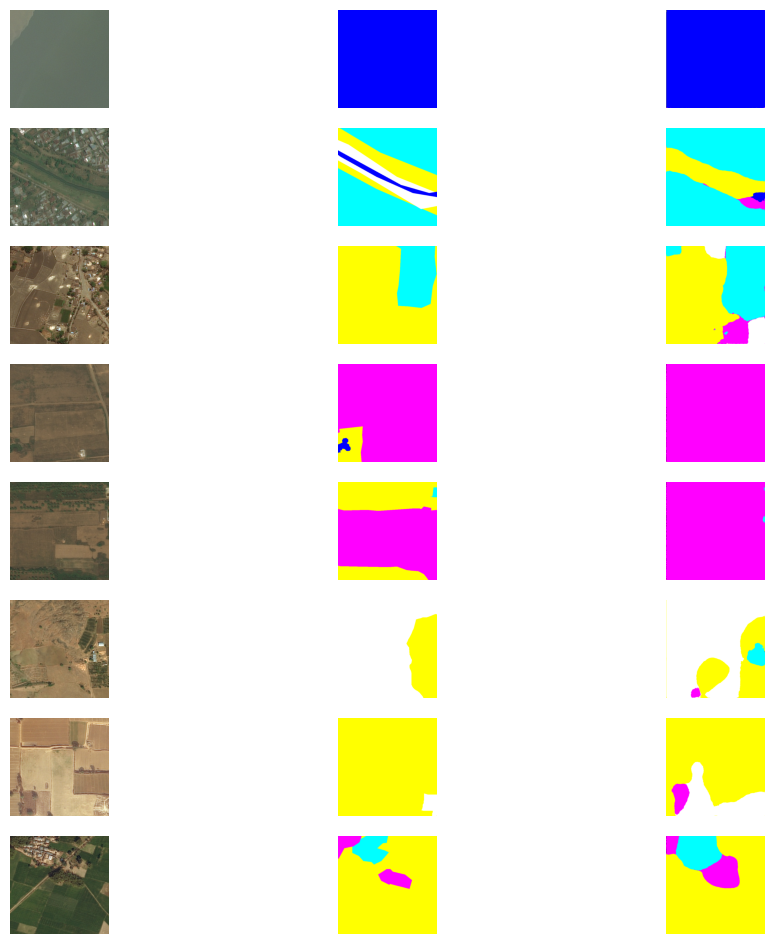

In [ ]:
test_images, test_masks = next(iter(testloader))

torch.set_grad_enabled(False)
model.eval()
pred_masks = model(test_images.to("cuda"))
visualize(test_images, test_masks, pred_masks.softmax(dim=1).argmax(dim=1))

## Metrics

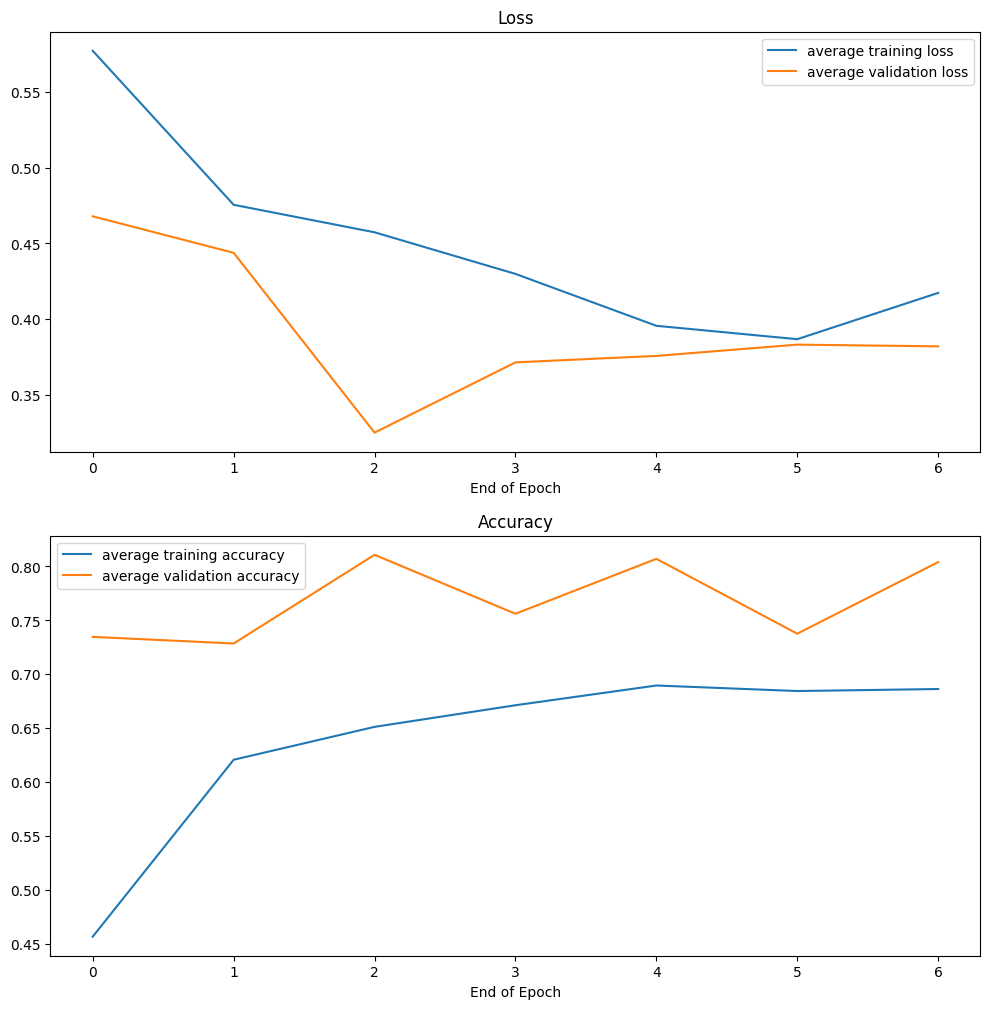

In [ ]:
metrics_df = pd.read_csv("plotting_metrics_2.csv")

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
metrics_df.plot(x="epoch", y=["train_loss_epoch", "val_loss_epoch"], ax=axs[0], title="Loss", xlabel="End of Epoch")
axs[0].legend(["average training loss", "average validation loss"])
metrics_df.plot(x="epoch", y=["train_accuracy_epoch", "val_accuracy_epoch"], ax=axs[1], title="Accuracy", xlabel="End of Epoch")
axs[1].legend(["average training accuracy", "average validation accuracy"])

plt.savefig("metrics_plot.png")
plt.show()